# Stochastic Volatility Inspired Model
------------------
> **Idriss Afra**

This project aims to construct the Implied Volatility surface under the Stochastic Volatility Inspired (SVI) model.

##The SVI Parameterization

The SVI is a parametric model with five parameters per market tenor : $\Gamma_T :=$ {$a, b, \rho, m, \sigma$}. It models the implied total variance :

$$
\sigma_{Imp}^{2}(k, \Gamma_T) . T = \omega(k, \Gamma_T):= a + b × \left[\rho (k - m) + \sqrt{(k-m)^2 + \sigma^2} \space \right]
$$

Where :

$$
k := ln \left( \frac{Strike}{F_T} \right) \in ℝ, \space a ∈ ℝ, \space b ≥ 0, \space |\rho| \lt 1, \space m \in ℝ, \space \sigma \gt 0, \space a + b \sigma \sqrt{1-\rho^2} \ge 0
$$

The last condition ensures that the minimum of the implied total variance is
positive. Note that we choose to use the log-forward moneyness for scaling purposes.

The five parameters control the implied total variance as follows :
* $a$ : Determines the overall level of total variance. Increasing $a$ increases the general level of
variance by a vertical translation of the smile.
* $b$ : Controls the angle between the left and right asymptotes (Convexity). Increasing $b$ tights the smile.
* $\rho$ : Determines the orientation of the graph. Increasing $\rho$ forces a counter-clockwise rotation of the smile.
* $m$ : Forces a horizontal translation of the smile. Increasing $m$ translates the smile to the right.
* $\sigma$ : Determines the curvature of the smile. Increasing $\sigma$ reduces the at-the-money (ATM) curvature
of the smile.

In [1]:
import numpy as np

def svi_v2T(k, a, b, rho, m, sigma) :
    """
    V2T formula under the SVI model.
    The log-moneyness k can be a scalar or an array, the function will return the SVI total variances.
    """
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma **2))

def svi_vol(k, a, b, rho, m, sigma, T) :
    """
    The SVI implied volatilities.
    The log-moneyness k can be a scalar or an array.
    """
    v2T = svi_v2T(k, a, b, rho, m, sigma)
    return np.sqrt(v2T / T)

## The Butterfly Arbitrage

In order to ensure the Butterfly free-arbitrage under the SVI model, the  probability density function of $S_T$ needs to be non-negative :

$$
f_{S_T}(K) = e^{rT} × \frac{d^2C_{BS}(K, T)}{dK^2}\gt 0
$$

And hence :

$$
p(k) := \frac{d^2C_{BS}(k, \omega(k, \Gamma_T))}{dK^2}\gt 0
$$

Where :

$$
\begin{align}
C_{BS}(k, \omega(k, \Gamma_T)) & = S e^{-qT} × \left(N(d_1) - e^k N(d_2)\right) \\
d_1 & = \frac{-k + ω(k, Γ_T) / 2}{\sqrt{ω(k, Γ_T)}} \\
d_2 & = d_1 - \sqrt{ω(k, Γ_T)}
\end{align}
$$

By differentiating the above Black-Scholes formula for any $k \in ℝ$, we get :
$$
p(k) = \frac{g(k)}{\sqrt{2Π.ω(k, Γ_T)}} × e^{-\frac{d_2^2}{2}}
$$
Where :
$$
g(k) := \left(1- \frac{k.ω'(k, Γ_T)}{2.ω(k, Γ_T)}\right)^2 - \frac{ω'(k, Γ_T)^2}{4} × \left( \frac{1}{ω(k, Γ_T)} + \frac{1}{4}\right) + \frac{ω''(k, Γ_T)}{2}
$$

<br>Therefore, the Butterfly free-arbitrage condition is : $ g(k) > 0 $



## Volatility on the Wings

To guarantee the Butterfly free-arbitrage, we should focus on the wings. In fact, we need to ensure that the  probability density function of $S_T$, and hence $g(k)$, are non-negative for extreme strikes.

Since :
* For ${k \to +∞}$ : $\omega_R(k, Γ_T) ≈ b(\rho + 1)k + [a-bm(\rho + 1)] $
* For ${k \to -∞}$ : $\omega_L(k, Γ_T) ≈ b(\rho - 1)k + [a-bm(\rho - 1)] $

Then for extreme strikes, $g(k)$ turns to the following quadratic equation :
$$
g(k) ≈ \frac{\beta^2}{4} \left(1 - \frac{\beta^2}{4}\right) k^2 + \frac{1}{4} \left(4\alpha\beta - \beta^3 - \frac{\alpha\beta^3}{2}\right) k + \frac{1}{4} \left(4\alpha^2 - \alpha\beta^2 - \frac{\alpha^2\beta^2}{4}\right)
$$
Where:
* For ${k \to +∞}$ : $\alpha=a - bm(\rho + 1)$ and $\beta=b(\rho + 1)$
* For ${k \to -∞}$ : $\alpha=a - bm(\rho - 1)$ and $\beta=b(\rho - 1)$

We avoid the arbitrage by considering that the discriminants $Δ_R$ and $Δ_L$ are negative and that $\frac{\beta^2}{4} \left(1 - \frac{\beta^2}{4}\right) \gt 0$. These conditions implies the following constraints :
* Constraint 1 : $(a-mb(\rho+1))(4-a+mb(\rho+1))-b^2(\rho+1)^2 > 0$
* Constraint 2 : $(a-mb(\rho-1))(4-a+mb(\rho-1))-b^2(\rho-1)^2 > 0$
* Constraint 3 : $0 < b^2(\rho+1)^2 < 4$
* Constraint 4 : $0 < b^2(\rho-1)^2 < 4$

## The Calendar Arbitrage

In order to ensure the Calendar free-arbitrage under the SVI model, we will need to add the following constraints for all the quoted tenors $(T_i)_{1\le i \le n}$ : $ω(k, Γ_{T_i}) > ω(k, Γ_{T_{i-1}})$

In practice, we will make sure that this inequality holds for moneyness falling between $50\%$ and $150\%$, as this is generally the moneyness range of instruments used for pricing models calibration.


## SVI Model Calibration

The calibration of the SVI model goes through a minimization process with the objective of replicating the market implied total variances.

For each market tenor $T$ :
$$
\Gamma_T \left( a^T, b^T, \rho^T, m^T, \sigma^T \right) = ArgMin_{(a, b, \rho, m, \sigma)} \frac{1}{N_T} ∑_{K_i ∈ Market}\left|\omega(k, \Gamma_T) - (\sigma_{K_i, T}^{Market}\sqrt{T})^2 \right|
$$

##SVI's Parameters Boundaries

We determine lower and upper boundaries for each SVI parameters in order to run
an efficient calibration that respects conditions related to the model and to avoid arbitrages :

* Parameter $a$ :
The minimum of the SVI total variance is located at the point : $ k^* = m - \frac{\rho \sigma}{\sqrt{1 - \rho^2}} $, and its value is : $ w_{min}(k) = a + b \sigma \sqrt{1 - \rho^2} $. Therefore, we must ensure that : $ a + b \sigma \sqrt{1 - \rho^2} > 0 $. We choose the following stronger condition : $ a > 0 $.
Finally, we can conclude that the condition on $a$ is : $
0 < 10^{-5} \le a \le max({w}^{market}) $

* Parameter $\rho$ :
The correlation coefficient must be in the interval : $ ]-1 , 1[ $

* Parameter $m$ :
This parameter controls the horizontal translation of the smiles. Therefore, we can floor and cap it with the following reasonable levels : $
2 \times min_i({k_i}^{market}) \le m \le 2 \times max_i({k_i}^{market})$

* Parameter $\sigma$ :
The parameter $\sigma$ should not take large value to ensure the curvature of the smiles near the ATM. Therefore, we can choose the following boundaries : $0.01 \le \sigma \le 1$

* Parameter $b$ :
Since the call prices convert to $0$ when $k$ tends to $+∞$, $d_1(k)$ must convert to $-∞$ when $k$ tends to $+∞$ (Rogers' Lemma).
In this case: $
lim_{k \to +∞} \frac{-k}{\sqrt{w(k)}} + \frac{\sqrt{w(k)}}{2} = -∞
$ 
Therefore : $
limsup_{k \to +∞} \frac{w(k)}{2k} = \frac{b (\rho + 1)}{2} \lt 1
$ 
To ensure the above equations, $b$ must respect the following conditions : $
10^{-3} \le b \lt 1 $

## SVI Model Implementation

In [2]:
from scipy.optimize import minimize

def svi_calibration(T, k, v2T) :
    """
    SVI model calibration : The function will return the calibrated SVI total variances.
    The argument T can be a scalar or an array.
    The constraints functions ensure the Calendar Spread and the Butterfly free-arbitrages.
    """
    if type(T) == int or type(T) == float :
        # SVI calibration on a single market tenor
        parameters0 = np.array([min(v2T), 0.1, -0.5, 0.1, 0.1]) # a, b, rho, m, sigma : Chosen arbitrary
        constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4})
        res = minimize(obj_func, x0=parameters0, args=(k, v2T), bounds=((1e-05, max(v2T)), (1e-03, 0.99), (-0.99, 0.99), (2*min(k), 2*max(k)), (1e-02, 0.99)), constraints=constraints)
        return res.x
    else :
        # SVI calibration on a set of market tenors
        parameters0 = np.array([min(v2T[0]) / 2, 0.1, -0.5, 0.1, 0.1]) # a, b, rho, m, sigma : Chosen arbitrary
        constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4})
        res = minimize(obj_func, x0=parameters0, args=(k[0], v2T[0]), bounds=((1e-05, max(v2T[0])), (1e-03, 0.99), (-0.99, 0.99), (2*min(k[0]), 2*max(k[0])), (1e-02, 0.99)), constraints=constraints)
        results = [res.x]
        for i in range(1, len(T)) :
            parameters0 = np.array([min(v2T[i]) / 2, 0.1, -0.5, 0.1, 0.1]) # a, b, rho, m, sigma : Chosen arbitrary
            constraints = ({'type': 'ineq', 'fun':constraint1}, {'type': 'ineq', 'fun':constraint2}, {'type': 'ineq', 'fun':constraint3}, {'type': 'ineq', 'fun':constraint4}, {'type': 'ineq', 'fun':constraint5, 'args': (k[i-1], results[i-1])})
            res = minimize(obj_func, x0=parameters0, args=(k[i], v2T[i]), bounds=((1e-05, max(v2T[i])), (1e-03, 0.99), (-0.99, 0.99), (2*min(k[i]), 2*max(k[i])), (1e-02, 0.99)), constraints=constraints)
            results.append(res.x)
        return results

def obj_func(parameters, k, v2T) :
    """
    The objective function of the SVI calibration : Sum-Squared Error (SSE) minimization between SVI and market total variances
    """
    svi  = svi_v2T(k, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
    sse = 0
    for i in range(len(k)) :
        sse += abs(svi[i] - v2T[i]) / len(k)
    return sse

def constraint1(parameters):
    """
    1st constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2 - eps

def constraint2(parameters):
    """
    2nd constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2 - eps

def constraint3(parameters):
    """
    3th constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return 4 - b**2 * (rho + 1)**2 - eps

def constraint4(parameters):
    """
    4th constraint
    """
    eps = 1e-5
    a, b, rho, m, sigma = parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]
    return 4 - b**2 * (rho - 1)**2 - eps

def constraint5(parameters, k, params_previous):
    """
    5th constraint : Calendar Spread Arbitrage-Free
    """
    log_moneyness = np.log(np.arange(0.5, 1.6, 0.1))
    log_moneyness = np.concatenate((k, log_moneyness))
    log_moneyness = np.unique(np.sort(log_moneyness))
    v2T_previous = svi_v2T(log_moneyness, params_previous[0], params_previous[1], params_previous[2], params_previous[3], params_previous[4])
    v2T  = svi_v2T(log_moneyness, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
    return -1 if (False in (v2T_previous < v2T)) else 1


## Application : Equity Options Market

The Equity listed options are quoted in prices and not in volatilities. Therefore, market volatilities need to be implied before applying the SVI fitting method.

To do so, we use the Newton-Raphson algorithm to find the root $\sigma_{Imp}(K_{market}, T_{market})$ of the following equation :

$$
BS(F_0, K, \sigma_{Imp}(K_{market},T_{market}), T) - MarketPrice(K_{market}, T_{market}) = 0
$$


In [3]:
from scipy.stats import norm

def black_scholes(flavor, K, T, S, r, vol, q=0) :
    """
    The Black-Scholes price.
    """
    v2T = vol**2 * T
    d1 = (np.log(S/K) + (r - q) * T + v2T / 2) / v2T**0.5
    d2 = d1 - v2T**0.5
    phi = 1 if flavor.upper() == "CALL" else  -1
    return phi * (S * math.exp(-q * T) * norm.cdf(phi * d1) - K * math.exp(-r * T) * norm.cdf(phi * d2))

def vega_bs(K, T, S, r, vol, q=0) :
    """
    The Black-Scholes Vega greek : The derivative of the option value with respect to the volatility of the underlying asset.
    """
    v2T = vol**2 * T
    d2 = (math.log(S/K) + (r - q) * T - v2T / 2) / v2T**0.5
    return K * math.exp(-r * T) * norm.pdf(d2) * T**0.5

In [4]:
import sys

def newton_raphson(market_price, init_vol, flavor, K, T, S, r, q=0):
    """
    The Newton-Raphson algorithm : Implied volatilities from market prices
    """
    eps = 1e-07
    vol = init_vol
    func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
    func_deriv = vega_bs(K, T, S, r, vol, q)
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
    next_vol = vol - func / func_deriv
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
    nb_iteration = 1
    while abs(next_vol - vol) > eps :
        vol = next_vol
        func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
        func_deriv = vega_bs(K, T, S, r, vol, q)
        error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
        next_vol = vol - func / func_deriv
        error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
        nb_iteration += 1
        error = sys.exit("The algorithm failed to converge. Please review the input data.") if nb_iteration > 300 else "No error."

    return next_vol

Let's take a close look at options on AAPL (Apple Inc. Stock). Let's consider AAPL 3W and 1M European options :

In [5]:
from datetime import date
import math

# Ignore Scipy warnings
import warnings
warnings.filterwarnings("ignore")

now_date = date(2023, 5, 8)
# Spot price
S0 = 173.5
# ZC rate
r = 5.17 / 100

# ******  First Tenor Data ************************
tenor1 = date(2023, 5, 26)
T1 = (tenor1 - now_date).days / 365.
discount1 = math.exp(-r * T1)
# Dividend yield
d1 = 2.25 / 100.
# OTM listed calls and puts prices
strikes1 = np.array([155, 160, 165, 170, 175, 180, 185, 190])
prices1 = np.array([0.215, 0.395, 0.82, 1.82, 2.53, 0.795, 0.185, 0.04])
flavors1 = np.array(["Put"] * 4 + ["Call"] * 4)
# Fwd price
F1 = S0 * math.exp(-d1 * T1) / discount1
# *************************************************

# ******  Second Tenor Data ***********************
tenor2 = date(2023, 6, 2)
T2 = (tenor2 - now_date).days / 365.
discount2 = math.exp(-r * T2)
# Dividend Yield
d2 = 1.62 / 100.
# OTM listed calls and puts prices
strikes2 = np.array([155, 160, 165, 170, 175, 180, 185, 190])
prices2 = np.array([0.345, 0.62, 1.175, 2.285, 3.125, 1.18, 0.335, 0.095])
flavors2 = np.array(["Put"] * 4 + ["Call"] * 4)
# Fwd price
F2 = S0 * math.exp(-d2 * T2) / discount2
# *************************************************

# Implied Volatilities using the Newton-Raphson Algorithm
implied_vols1 = []
implied_vols2 = []
for i in range(len(strikes1)):
    implied_vols1 += [newton_raphson(prices1[i], 0.2, flavors1[i], strikes1[i], T1, S0, r, d1)]
    implied_vols2 += [newton_raphson(prices2[i], 0.2, flavors2[i], strikes2[i], T2, S0, r, d2)]

# SVI Calibration on both market tenors
T = np.array([[T1], [T2]])
implied_vols = np.array([implied_vols1, implied_vols2])
k = np.array([np.log(strikes1 / F1), np.log(strikes2 / F2)])
v2T = (implied_vols**2) * T
params = svi_calibration(T, k, v2T)
params0, params1 = params[0], params[1]
print("Calibrated SVI parameters 3W : ", {"a" : round(params0[0], 4), "b" : round(params0[1], 4), "Rho" : round(params0[2], 4), "m" : round(params0[3], 4), "Sigma" : round(params0[4], 4)})
print("Calibrated SVI parameters 1M : ", {"a" : round(params1[0], 4), "b" : round(params1[1], 4), "Rho" : round(params1[2], 4), "m" : round(params1[3], 4), "Sigma" : round(params1[4], 4)})

# SVI V2T
svi_v2T0 = svi_v2T(k[0], params0[0], params0[1], params0[2], params0[3], params0[4])
svi_v2T1= svi_v2T(k[1], params1[0], params1[1], params1[2], params1[3], params1[4])

# SVI Vol
svi_v0 = svi_vol(k[0], params0[0], params0[1], params0[2], params0[3], params0[4], T[0])
svi_v1= svi_vol(k[1], params1[0], params1[1], params1[2], params1[3], params1[4], T[1])

Calibrated SVI parameters 3W :  {'a': 0.0006, 'b': 0.0175, 'Rho': -0.4928, 'm': 0.0225, 'Sigma': 0.0657}
Calibrated SVI parameters 1M :  {'a': 0.0015, 'b': 0.0162, 'Rho': -0.4864, 'm': 0.0503, 'Sigma': 0.0271}


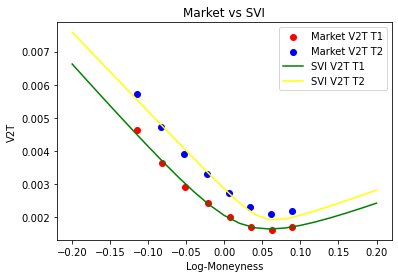

In [6]:
# Fitting Results : Market vs SABR

import matplotlib.pyplot as plt

x_axis = np.linspace(-0.2, 0.2, 21)
svi_v2T0 = svi_v2T(x_axis, params0[0], params0[1], params0[2], params0[3], params0[4])
svi_v2T1= svi_v2T(x_axis, params1[0], params1[1], params1[2], params1[3], params1[4])

plt.ylabel("V2T")
plt.xlabel("Log-Moneyness")
plt.title("Market vs SVI")
plt.scatter(k[0], v2T[0], color="red", label="Market V2T T1")
plt.scatter(k[1], v2T[1], color="blue", label="Market V2T T2")
plt.plot(x_axis, svi_v2T0, color="green", label="SVI V2T T1")
plt.plot(x_axis, svi_v2T1, color="yellow", label="SVI V2T T2")
plt.legend(loc="upper right")
plt.show()